# Gyro bias stability trending

This notebook presents trending plots related to the stability of the gyro bias over a 30-minute timescale.

The key metric is the $\Delta$-bias, defined as the change in pitch / yaw gyro bias over 30 minutes.  This gives a good estimate of bias excursions on a timescale that is important for inducing maneuver errors.  The integrated bias error (in arcsec) over 30 minutes was also investigated but gives qualitatively similar results.

Tracking  the long-term bias *RMS variations* has no direct bearing on maneuver errors since one can see large RMS variations due to slow changes over many hours.  These slow changes do not result in large maneuver errors.

The roll bias is not considered here because that is strongly influenced by issues in ACA centroiding (e.g. tracking warm pixels) and thus does not cleanly reflect gyro behavior.

The primary dataset used for this analysis is a database of gyro-bias values taken at 1-minute intervals since 2010.  Only intervals within a Kalman dwell (as defined by the kadi `dwell` event) are used.  Within each interval the median gyro bias (`AOGBIAS<N>`) is recorded.  Note that the dwell intervals used here are taken to start 20 minutes after the Kalman filter starts so the gyro bias estimate is converged.  This misses some gyro bias excursions that happen during a manuever, but the bias behavior may be different during that time.

In [1]:
from Ska.Matplotlib import plot_cxctime
from Ska.Numpy import interpolate
from astropy.table import Table
import matplotlib.pyplot as plt
from Chandra.Time import DateTime
from Ska.engarchive import fetch_eng as fetch

import shelve
%matplotlib inline

In [2]:
R2A = np.degrees(1) * 3600

In [3]:
def bias_variability(bias, delta_mins=30, integrate=True):
    """
    Get running estimate of bias variability, either as a difference between
    samples separated by ``delta_mins`` (integrate=False) or as the integral
    of ``delta_mins`` of samples (after subtracting the value of the first
    sample in the span).

    :param bias: 3 x N array of bias values [arcsec/sec] sampled at 1 minute intervals
    :param delta_mins: difference or integration interval [minutes]
    :param integrate: perform difference or integration

    :returns: bias variability (3 x N array), either arcsec/sec (integrate=False) or arcsec
    """

    # Integrate between x0, x1 of (y - y(t0)) = Int(y) - (t1-t0) * y(t0)
    # dt = 1 (minute) here, but bias is arcsec/sec, so mult by 60 later
    # to get arcsec.
    if integrate:
        bias_sum = np.cumsum(bias, axis=1)
        bias_sum_var = (bias_sum[:, delta_mins:] - bias_sum[:, :-delta_mins] 
                        - delta_mins * bias[:, :-delta_mins])
        bias_var = bias_sum_var * 60
    else:
        bias_var = bias[:, delta_mins:] - bias[:, :-delta_mins]

    return bias_var

In [4]:
def get_bias_vars_times(biases, integrate=False, delta_mins=5, unique_times=False, start='1999:001'):
    datestart = DateTime(start).date
    biases = {date: val for date, val in biases.items() if date > datestart}
    bias_vars_list = [bias_variability(bias, integrate=integrate, delta_mins=delta_mins) 
                      for bias in biases.values()]
    bias_vars = np.hstack(bias_vars_list)

    times = DateTime(biases.keys()).secs
    times_list = []
    for time, bias_var in zip(times, bias_vars_list):
        if unique_times:
            ts = time + 60 * np.arange(len(bias_var[0]))
        else:
            ts = np.repeat(time, len(bias_var[0]))  # one time stamp per dwell
        times_list.append(ts)

    times = np.hstack(times_list)
    
    return bias_vars, times

In [5]:
# Read all the dwells into memory
biases = dict(shelve.open('biases4.shelve', protocol=-1).items())

In [6]:
# Compute delta-bias over 30-minute values for each interval
bias_vars, bias_times = get_bias_vars_times(biases, delta_mins=30, unique_times=True, integrate=False)

In [7]:
# Put into a table and assign an integer "day" number (days since 1998.0)
t = Table([bias_times, bias_vars[1], bias_vars[2]], names=['time', 'dbias_pitch', 'dbias_yaw'])
t['day'] = t['time'] // (60 * 60 * 24)
tg = t.group_by('day')

In [8]:
# Compute daily max for abs(delta bias) in each axis
ngrp = len(tg.groups)
tga = dict()
for axis in ('pitch', 'yaw'):
    db = 'dbias_{}'.format(axis)
    tga[axis] = Table([np.zeros(ngrp), np.zeros(ngrp)], names=['time', 'dbias'])
    for ii, grp in enumerate(tg.groups):
        vals = np.abs(grp[db])
        jj = np.argmax(vals)
        tga[axis]['time'][ii] = grp['time'][jj]
        tga[axis]['dbias'][ii] = vals[jj]        

In [9]:
# Plot daily maxes and capture big bias jogs (> 0.03 arcsec/sec)
def plot_daily_maxes(tga, start='2000:001', stop=None):
    tstart = DateTime(start).secs
    tstop = DateTime(stop).secs
    
    plt.figure(figsize=(8, 4))
    bigs = []

    for axis, marker in (('pitch', 'b.'), ('yaw', 'r.')):
        tgaa = tga[axis]
        ok = (tgaa['time'] >= tstart) & (tgaa['time'] < tstop)
        tgaa = tgaa[ok]
        plot_cxctime(tgaa['time'], tgaa['dbias'], marker, alpha=0.5, label=axis)
        idxs = np.where(tgaa['dbias'] > 0.03)[0]
        if len(idxs) > 0:
            for ii in idxs:
                print('Delta {:5s} bias={:.3f} at {}'
                      .format(axis, tgaa['dbias'][ii], DateTime(tgaa['time'][ii]).date))
                bigs.append((axis, ii))

    plt.grid();
    plt.ylabel('arcsec / sec')
    plt.margins(0.05);
    plt.legend(loc='upper left', fancybox=True, framealpha=0.5, numpoints=1, fontsize='medium')
    plt.title('Daily max $\Delta$-bias over 30 minutes')
    
    return bigs

Delta pitch bias=0.032 at 2010:262:01:48:47.188
Delta pitch bias=0.032 at 2016:301:07:31:54.862
Delta pitch bias=0.030 at 2016:339:12:37:55.155
Delta pitch bias=0.031 at 2017:040:01:56:57.887
Delta pitch bias=0.043 at 2017:082:04:29:05.298
Delta yaw   bias=0.040 at 2013:242:20:07:29.501


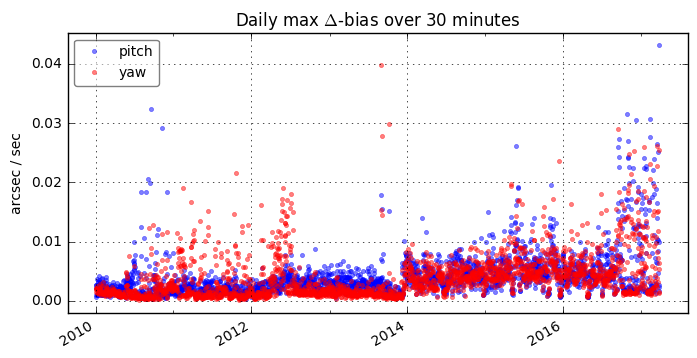

In [10]:
bigs = plot_daily_maxes(tga)

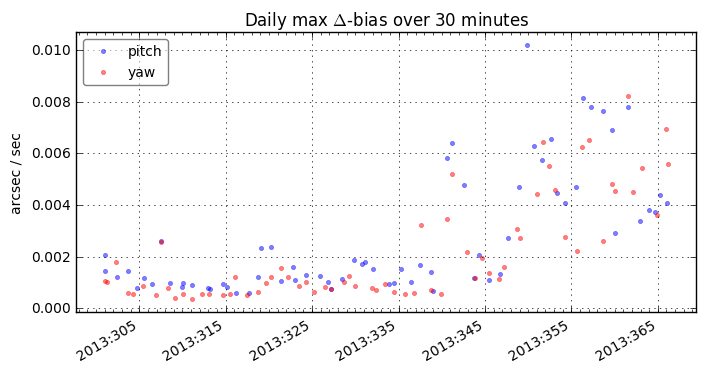

In [11]:
plot_daily_maxes(tga, '2013:300', '2014:001');

Delta pitch bias=0.032 at 2016:301:07:31:54.862
Delta pitch bias=0.030 at 2016:339:12:37:55.155
Delta pitch bias=0.031 at 2017:040:01:56:57.887
Delta pitch bias=0.043 at 2017:082:04:29:05.298


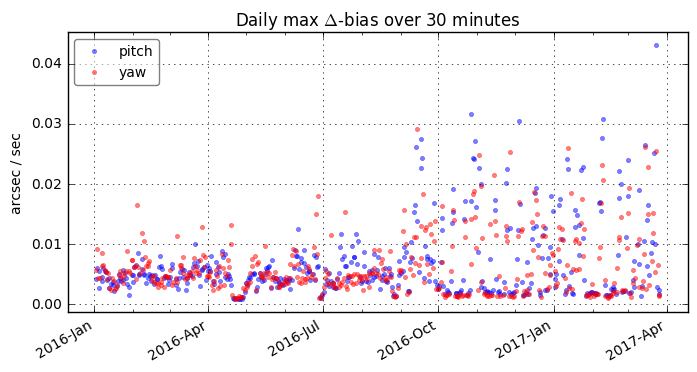

In [12]:
plot_daily_maxes(tga, '2016:001');

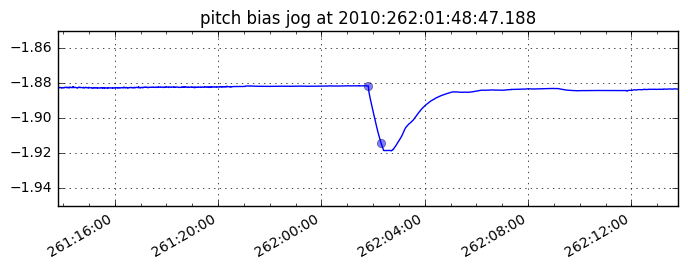

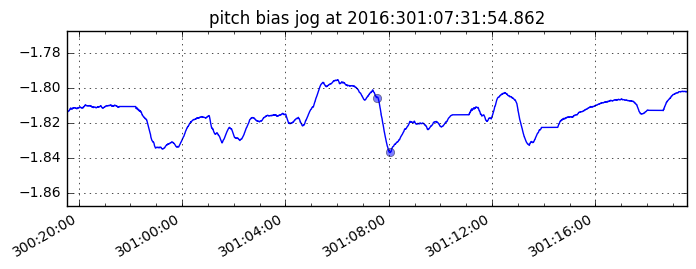

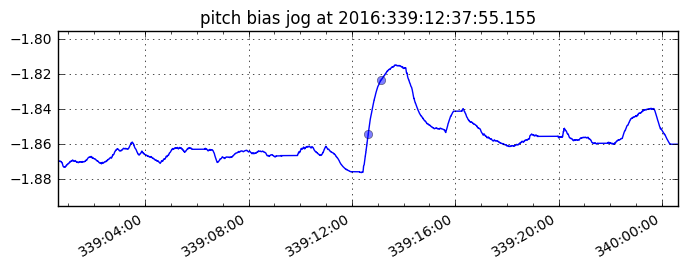

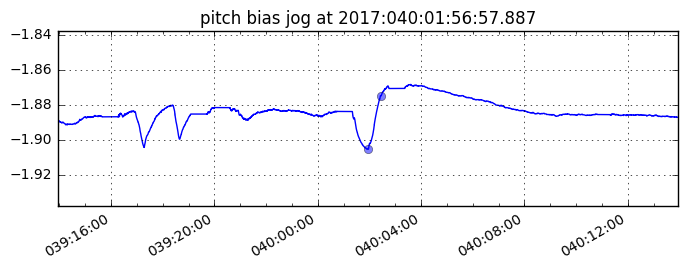

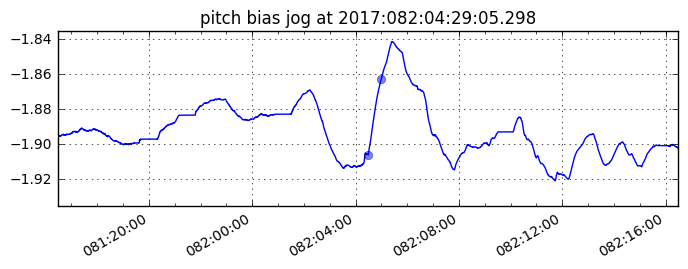

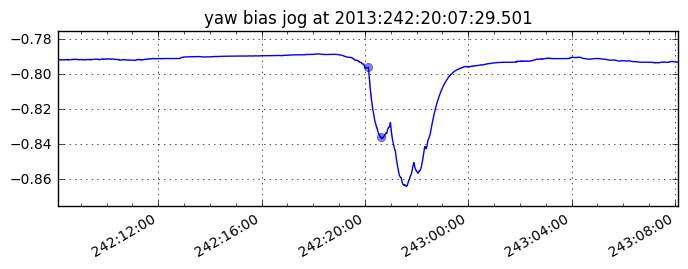

In [15]:
# Plot the outliers to make sure they are reasonable
for axis, ii in bigs:
    naxis = 2 if axis == 'pitch' else 3
    tm = tga[axis]['time'][ii]
    dat = fetch.Msid('aogbias{}'.format(naxis), tm - 43200, tm + 43200)
    plt.figure(figsize=(8 ,2.5))
    vals = dat.vals * R2A
    i0, i1 = np.searchsorted(dat.times, [tm, tm + 1800])
    ts = dat.times[[i0, i1]]
    vs = vals[[i0, i1]]
    plot_cxctime(dat.times, dat.vals * R2A)
    plot_cxctime(ts, vs, 'o', alpha=0.5)
    y0, y1 = plt.ylim()
    ym = np.mean([y0, y1])
    plt.ylim(ym - 0.05, ym + 0.05)  # Replicate daily plot y-range
    plt.title('{} bias jog at {}'.format(axis, DateTime(tm).date))
    plt.grid();

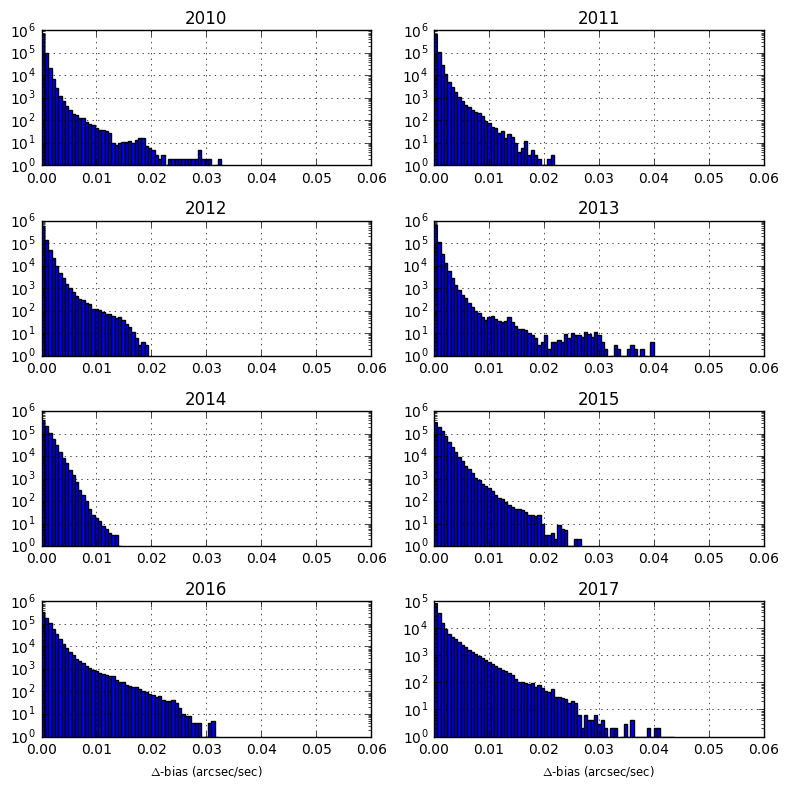

In [14]:
# Plot histogram of delta biases for each year
bins = np.linspace(0, 0.06, 100)
plt.figure(figsize=(8, 8))
for ii, year in enumerate(range(2010, 2018)):
    plt.subplot(4, 2, ii + 1)
    date0 = DateTime('{}:182'.format(year))
    ok = (bias_times > (date0 - 182).secs) & (bias_times < (date0 + 182).secs)
    py = np.concatenate([bias_vars[1][ok], bias_vars[2][ok]])
    plt.hist(np.abs(py), log=True, bins=bins);    
    plt.grid()
    plt.title('{}'.format(year))
    if ii >= 6:
        plt.xlabel('$\Delta$-bias (arcsec/sec)', fontsize='small')
plt.tight_layout()